# Part 2 - Generalized Linear Model

**TODO** Introduction - worum gehts hier


**Execute this first:**

In [46]:
from matplotlib.pyplot import *
%matplotlib inline
import numpy as np

def reduce_resolution(array,factor,sum_spikes=False):
    """ 
    Reduces the temporal resolution of an array of spike trains.
    
    When this causes multiple spikes to fall in one bin, we count only one.
    In other words, this is a potentially lossy procedure, especially for dense
    spike trains.
    
    Arguments:
        array: 4D numpy array. Reduction will occur along the last dimension (T).
        factor: integer to divide the number of time bins by.
      
    Returns:
        4D numpy array, similar as input but last dimension with length T/factor.
    """
    assert type(factor) is int
    
    reduced_shape = (array.shape[0],array.shape[1],array.shape[2],array.shape[3]/np.round(factor))
    spikes_reduced = np.zeros(reduced_shape) # create a shorter result array
    for idx in np.ndindex(array.shape[0:3]): # for all indices along the first 3 dimensions
        spiketimes = (spikes[idx].nonzero()[0] / factor).astype(int) # get spiketimes, divide by factor
        for spiketime in spiketimes:
            spikes_reduced[idx[0],idx[1],idx[2],spiketime] += 1 # increment result array by 1 at the divided spiketimes
    if not sum_spikes:
        spikes_reduced  = spikes_reduced >= 1
    
    spikecount_difference = (np.sum(spikes) - np.sum(spikes_reduced)).astype(int)
    if spikecount_difference > 0:
        print "Lost "+str(spikecount_difference)+" spikes through resolution reduction."
    return spikes_reduced    

(-0.01, 0.05)

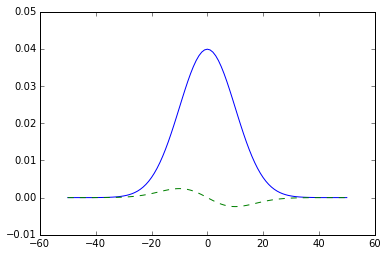

In [141]:
from scipy.ndimage.filters import gaussian_filter1d

sigma = 10#ms

x = np.arange(-50,51)
y = np.zeros(101)
y[50] = 1

plot(x,gaussian_filter1d(y, sigma=sigma, order=0), "-")
plot(x,gaussian_filter1d(y, sigma=sigma, order=1), "--")
ylim([-0.01,0.05])

### Loading data

**TODO** Description of the data (Origin, meaning of "cell","condition","trial"...)


Two things happen in the next cell: We load spike data from a file and we reduce their temporal resolution (using the function defined above), so that later computations aren't too slow. Feel free to reduce the resolution even more if computation times are still too long, while of course remembering that information gets thrown away in that process.

[    0.     0.   155.   252.   303.   402.   506.   638.   737.   763.
   829.   876.   979.  1088.  1220.  1274.  1340.  1430.  1545.  1686.
  1741.  1842.  1911.  2003.  2099.  2217.  2423.  2575.  2684.  2880.]


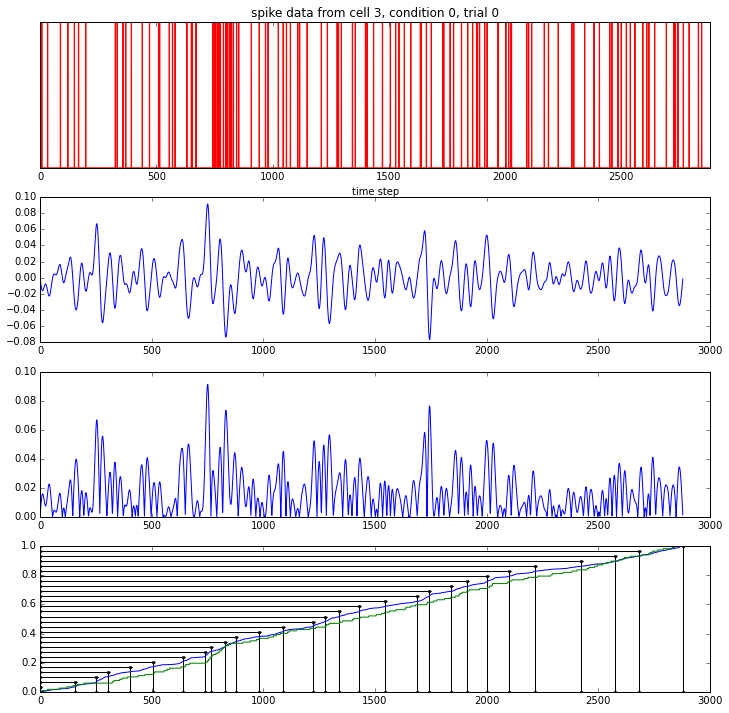

In [198]:
with np.load('data.npz') as archive:
    spikes = archive['spikes_outputencoding']

max_spikes_per_bin = 5
spikes = reduce_resolution(spikes,factor=max_spikes_per_bin, sum_spikes=True) # <-- reduction factor

cell = 3
condition = 0
all_spiketrains = spikes[cell,condition,:,:]
N = spikes.shape[2] # number of trials
T = spikes.shape[3] # length of a trial
x = np.arange(T)

figure(figsize=(12,12))

trial = 0
single_spiketrain = spikes[cell,condition,trial,:]


num_knots = 30
filtered_spiketrain = gaussian_filter1d(all_spiketrains.sum(axis=0), sigma=sigma, order=0)
filtered_derivative_spiketrain = gaussian_filter1d(all_spiketrains.sum(axis=0), sigma=sigma, order=1)
cumulative_absolute_filtered_derivative_spiketrain = np.cumsum(abs(filtered_derivative_spiketrain))

percentiles = np.linspace(0,1,num_knots)
knots = np.zeros_like(percentiles)

current_perc = 1
for step in range(T):
    if cumulative_absolute_filtered_derivative_spiketrain[step]/cumulative_absolute_filtered_derivative_spiketrain[-1] > percentiles[current_perc]:
        current_perc+=1
        knots[current_perc] = step

knots[-1] = T
print knots

subplot(4,1,1)
plot(x,single_spiketrain,'r')
title('spike data from cell '+str(cell)+', condition '+str(condition)+', trial '+str(trial))
ylim([0,0.2])
xlim([0,T])
yticks([])
xlabel('time step')

subplot(4,1,2)
plot(x,filtered_derivative_spiketrain)

subplot(4,1,3)
plot(x,abs(filtered_derivative_spiketrain))

subplot(4,1,4)

for px,py in zip(knots, percentiles):
    plot([0,px,px],[py,py,0],'k.-')
    
plot(x,np.cumsum(abs(filtered_derivative_spiketrain))/abs(filtered_derivative_spiketrain).sum())
plot(x,np.cumsum(single_spiketrain)/single_spiketrain.sum())

In [184]:
np.linspace(0,T,15)

array([    0.        ,   205.71428571,   411.42857143,   617.14285714,
         822.85714286,  1028.57142857,  1234.28571429,  1440.        ,
        1645.71428571,  1851.42857143,  2057.14285714,  2262.85714286,
        2468.57142857,  2674.28571429,  2880.        ])

## Excercise 1

** TODO ** text.

In [73]:
print spline_bases.shape, spikes_nospikes.shape

(1440, 17) (1440, 2)


-3601.4958439


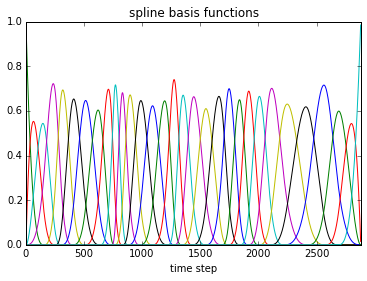

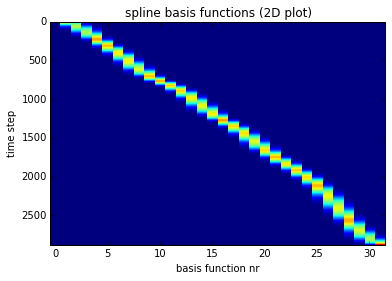

In [199]:
import statsmodels.api as sm
import splines


# spline_order = ...
# knots = ...
# spline_bases = ...
# dm = ...

# model = sm.GLM(...)
# fitted_model = model.fit()
# prediction = fitted_model.predict(...)

spikes_across_trials = all_spiketrains.sum(axis=0, keepdims=True).T

spikes_nospikes = np.hstack([spikes_across_trials, N*max_spikes_per_bin-spikes_across_trials])

spline_order = 3                                                      # solution
knots = splines.augknt(knots, spline_order)
#knots        = splines.augknt(np.linspace(0,T,30),spline_order)       # solution
spline_bases = np.array(splines.spcol(range(T),knots,spline_order))   # solution

model = sm.GLM(spikes_nospikes,spline_bases,family=sm.families.Binomial())      # solution
fitted_model = model.fit()                                            # solution
prediction = fitted_model.predict(spline_bases)                       # solution



figure()
plot(spline_bases)
xlim([0,T])
title('spline basis functions')
xlabel('time step')

figure()
imshow(spline_bases,aspect='auto',interpolation='nearest')
title('spline basis functions (2D plot)')
ylabel('time step')
xlabel('basis function nr')

print fitted_model.llf

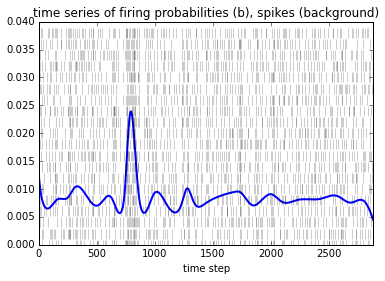

In [190]:
spike_y,spike_t = np.where(all_spiketrains)
ylims   = (0,0.04)

figure()
plot(prediction,linewidth=2)
plot(spike_t,spike_y*ylims[1]/N,"k|", alpha=0.4,ms=10)
ylim(ylims)
xlim([0,T])
title('time series of firing probabilities (b), spikes (background)')
xlabel('time step')

## Exercise 2

Number of knots: 10.  Log-Likelihood: -11335.2
Number of knots: 20.  Log-Likelihood: -11314.8
Number of knots: 30.  Log-Likelihood: -11290
Number of knots: 40.  Log-Likelihood: -11261.8
Number of knots: 50.  Log-Likelihood: -11239
Number of knots: 60.  Log-Likelihood: -11235.2
Number of knots: 70.  Log-Likelihood: -11220.7
Number of knots: 80.  Log-Likelihood: -11240.6
Number of knots: 90.  Log-Likelihood: -11257.9
Number of knots: 100.  Log-Likelihood: -11268.9
The highest Log-Likelihood of -11220.7 was found for 70 knots.


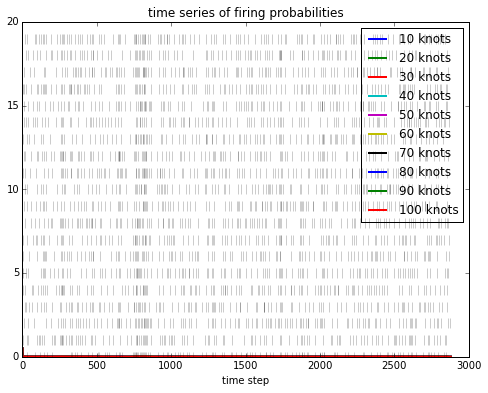

In [102]:
#def ll(ps,xs):
#    ...

def ll(ps,xs):                                                                 # solution
    return sum(xs*np.log(ps) +(1 - xs) * np.log(1-ps))                         # solution

num_knots_candidates = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

n_crossvalidation    = 5
num_training_trials  = N/n_crossvalidation

best_loglikelihood = -np.inf
best_num_knots     = None

figure(figsize=(8,6))
for num_knots in num_knots_candidates:
#    ...
    knots = splines.augknt(np.linspace(0,T,num_knots),spline_order)              # solution
    spline_bases = np.array(splines.spcol(range(T),knots,spline_order))          # solution
    
    loglikelihood = 0                                                            # solution
    for i in range(5):                                                              # solution
        testing_spikes  = all_spiketrains[i*num_test_trials:(i+1)*num_test_trials,:].sum(axis=0)
        training_spikes =   all_spiketrains[:i*num_test_trials,:].sum(axis=0,keepdims=True).T + \
                            all_spiketrains[(i+1)*num_test_trials:,:].sum(axis=0,keepdims=True).T
        
        training_spikes_nospikes = np.hstack([training_spikes, num_training_trials*max_spikes_per_bin-training_spikes])
        model = sm.GLM(training_spikes_nospikes,spline_bases,family=sm.families.Binomial())# solution
        fitted_model = model.fit()                                               # solution

        prediction = fitted_model.predict(spline_bases)                          # solution
        loglikelihood += ll(prediction,testing_spikes)                                # solution
        # Plot the resulting prediction for the first trial                      # solution
        if i==0:                                                                 # solution
            plot(prediction[:T],linewidth=2)                                     # solution
    # Update the current best number of knots                                    # solution
    if loglikelihood > best_loglikelihood:                                       # solution
        best_loglikelihood = loglikelihood                                       # solution
        best_num_knots = num_knots                                               # solution
    print "Number of knots: %d.  Log-Likelihood: %g" % (num_knots, loglikelihood)# solution


print "The highest Log-Likelihood of %g was found for %d knots." % (best_loglikelihood, best_num_knots)
plot(spike_t, spike_y, "k|", alpha=0.4, ms=10)
legend(map(lambda n: "%d knots" % n, num_knots_candidates))
#ylim([0,0.04])
title('time series of firing probabilities')
xlabel('time step');